# Stable Lorenz
By Alan Kaptanoglu

This example builds a data-driven dynamical system model for the Lorenz system, and illustrate the use of the new SINDy extension that searches for stable systems with energy-preserving quadratic nonlinearities. This builds off of the new constrained SINDy algorithm based on SR3. The stability analysis for the Lorenz attractor, as well as the Theorem for stability utilized in this SINDy algorithm, can be found at https://arxiv.org/pdf/1310.0053.pdf.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
import scipy.integrate as integrate 

In [10]:
r = 3
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

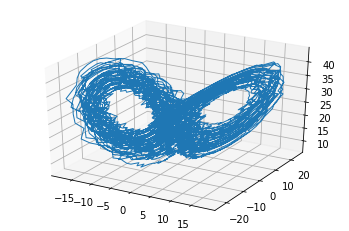

In [20]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = (0,1,20)

x_t = integrate.odeint(lorenz_deriv, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
noise = np.random.normal(0,0.5,x_t.shape[0])
for i in range(r):
    x_t[:, i] = x_t[:, i] + noise
    
x, y, z = x_t.T
plt.plot(x, y, z,linewidth=1)

In [31]:
# Custom library order is required for the constraint indexing!
r = 3
threshold = 0.05
poly_order = 2

# Set library functions and names
if poly_order == 2:
   library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
   library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
else:
   library_functions = [lambda x:x]
   library_function_names = [lambda x:x]    
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

# Since this is noisy data, we need to explicitly constrain the SINDy coefficients
# to have this energy-preserving quadratic structure
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1

# Construct the 4-index (constant) PL tensor
Nr = int((r**2 + 3*r)/2.0)
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0
                    
# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)
                    
# Construct the 4-index (constant) PQ tensor
PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0
            
    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0
        
# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

# initialize the true m and true P for comparison at the end
m = [0, 0, rho + sigma]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - i] = m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)      
P_test = PL_tensor - mPQ

New SR3: 
x0' = -10.096 x0 + 10.142 x1
x1' = 26.207 x0 + -0.065 x1 + -0.951 x0x2
x2' = -2.621 x2 + 0.957 x0x1
optimal m =  [150.00256368  -3.17435603  33.4146774 ]
As:  [[-10.09643998  18.17465295   0.        ]
 [ 18.17465295  -0.0652487    0.        ]
 [  0.           0.          -2.62055719]]
As eigvals:  [-23.93486804  13.77317935  -2.62055719]
As:  [[-10.09643998  -0.01207904  -0.06055961]
 [ -0.01207904  -0.0652487    0.        ]
 [ -0.06055961   0.          -2.62055719]]
As eigvals:  [-10.09694507  -2.62006665  -0.06523416]


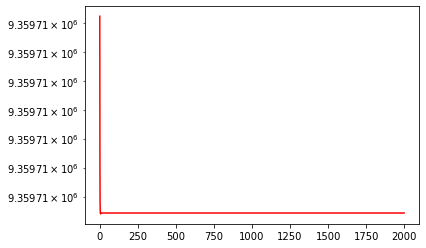

In [35]:
# Put everything in and run the new SINDy algorithm
eta=1.0e5
nu=1.0
sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=2000, tol=1e-10,
                           thresholder="l0", eigmin=-1e20, eigmax=-0.1, 
                           alpha=0.5*min(nu,eta), beta=0.5*eta,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_t, t=t)
print('New SR3: ')
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
print('optimal m = ', sindy_opt.m_history_[0])

# reconstruct the P associated with the optimal m
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ

# Print the eigenvalues of (PW)_true and (PW)_sindy
As = np.tensordot(P_test, Xi, axes=([3, 2], [0, 1]))
print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print('As eigvals: ', eigvals)
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print('As eigvals: ', eigvals)

# Plot the objective function history
plt.figure()
plt.semilogy(sindy_opt.objective_history,'r')
sindy_opt.history_ = np.asarray(sindy_opt.history_)

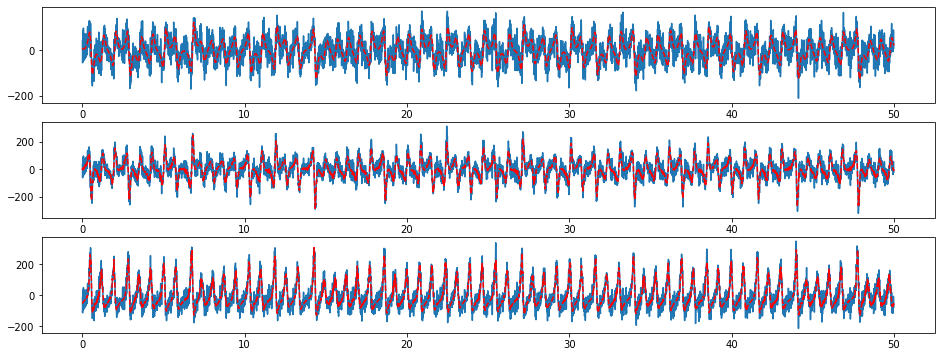

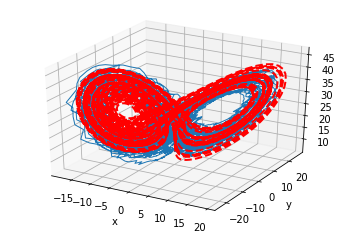

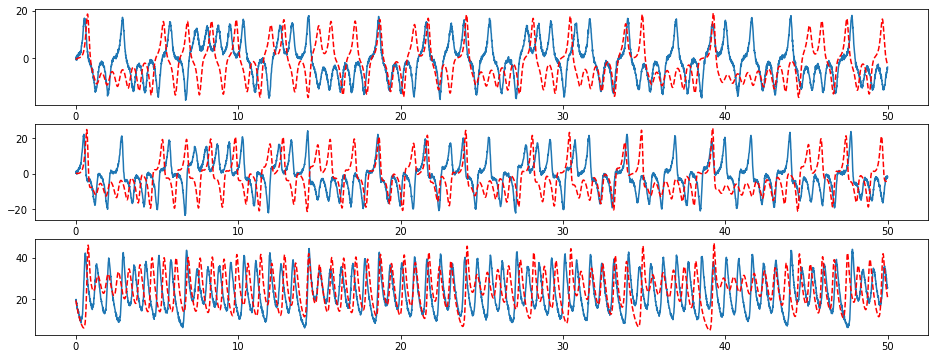

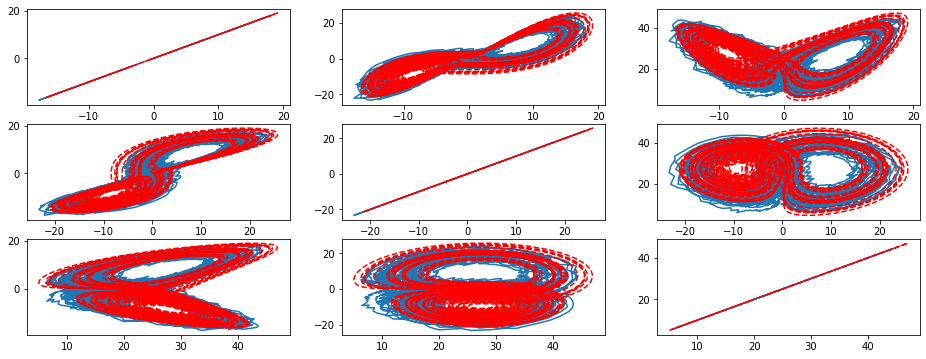

In [36]:
# Plot X and Xdot predictions against the original data
x_dot = model.differentiate(x_t, t=t)
x_dot_pred = model.predict(x_t)
plt.figure(figsize=(16,6))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t, x_dot[:, i])
    plt.plot(t, x_dot_pred[:, i], 'r--')

tmax = len(t)-1
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
plt.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=1)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x_t[0,:], t, integrator_kws=integrator_keywords)
plt.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'r--', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')

plt.figure(figsize=(16,6))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t, x_t[:, i])
    plt.plot(t, x_pred[:, i], 'r--')
    
plt.figure(figsize=(16,6))
for i in range(r):
    for j in range(r):
        plt.subplot(r, r, i*r + j + 1)
        plt.plot(x_t[:, i], x_t[:, j])
        plt.plot(x_pred[:tmax, i], x_pred[:tmax, j], 'r--')

In [39]:
# Scan the (eta, gamma) model space
Neta = 30
Neig = 30
eta_scan = np.logspace(2, 10, Neta)
eigmax_scan = np.logspace(-2, 3, Neig)
A_scan = np.zeros((r, Neta, Neig))
Xi_true = np.asarray([[-10.0,28.0,0.],[10.0,-1.0,-0.],[0.,0.,-8.0/3.0],
        [ 0.,0.,1.0],[0.,-1.0,0.],[0.,0.,0.],[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]])
m_true = [0, 0, rho + sigma]
As_true = np.tensordot(P_test, Xi_true, axes=([3, 2], [0, 1]))
Xi_contours = np.zeros((Neta, Neig))
A_contours = np.zeros((Neta, Neig))
Xdot_contours = np.zeros((Neta, Neig))
objectives = []
m_scan = []
X = []
Xdot = []
Xis = []

x0_rand = np.random.rand(3)-0.5
x_test = integrate.odeint(lorenz_deriv, x0_rand, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
noise = np.random.normal(0.0,1.0,x_test.shape[0])
for i in range(r):
    x_test[:,i] = x_test[:,i] + noise
    
for i in range(Neta):
    print(i)
    for j in range(Neig):
        
        sindy_opt = ps.proxgradSR3(threshold=threshold, nu=nu, eta=eta_scan[i],
                                  PL=PL_tensor, PQ=PQ_tensor, max_iter=2000, tol=1e-10,
                                  thresholder="l0", eigmin=-(10**20), eigmax=-eigmax_scan[j],
                                  alpha=0.5*min(eta_scan[i], nu),beta=0.5*eta_scan[i], 
                                  constraint_lhs=constraint_matrix,
                                  constraint_rhs=constraint_zeros,
                                  constraint_order="feature")

        model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
        
        model.fit(x_t, t=t)
        opt_m = sindy_opt.m_history_[-1]
        Xi = model.coefficients().T
        mPQ = np.zeros(PL_tensor.shape)
        for ii in range(r):
            for jj in range(ii+1, r):
                mPQ[ii, jj, :, int((ii+1)/2.0*(2*r-ii)) + jj - 1 - ii] = opt_m
        for ii in range(r):
            mPQ[ii, ii, :, Nr - r + ii] = opt_m

        for ii in range(r):
            for jj in range(Nr):
                mPQ[:, :, ii, jj] = 0.5 * (mPQ[:, :, ii, jj] + mPQ[:, :, ii, jj].T)    
        P_tensor = PL_tensor - mPQ
        As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        eigvals, eigvecs = np.linalg.eig(As)
        A_scan[:, i, j] = eigvals
        m_scan.append(opt_m)
        Xi_contours[i, j] = np.linalg.norm(Xi_true-Xi)
        A_contours[i, j] = np.linalg.norm(As_true-As)
        x_dot_pred = model.predict(x_test)
        Xdot_contours[i, j] = np.linalg.norm(x_dot[1:-1,:] - x_dot_pred[1:-1,:])
        x_pred = model.simulate(x0_rand, t, integrator_kws=integrator_keywords)
        Xdot.append(x_dot_pred)
        X.append(x_pred)
        Xis.append(Xi)
        objectives.append(sindy_opt.objective_history)

0


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/

1


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/

2


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/loc

3


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/loc

4


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWar

5


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, OD

6


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWar

7


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWar

8


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWar

9


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


11


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


12


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


13


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


14
15


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


16
17
18
19
20
21
22
23
24
25
26
27
28
29


[[-8.90441125e+00  2.99882743e-15  1.61178921e+01]
 [-1.26040821e+01 -4.88632973e-16  1.60373131e+01]
 [ 1.12601875e+01 -1.89772231e-15  1.71881661e+01]
 ...
 [ 0.00000000e+00  0.00000000e+00  3.79746795e+01]
 [ 0.00000000e+00  0.00000000e+00  3.79746795e+01]
 [ 0.00000000e+00  0.00000000e+00  3.79746795e+01]]


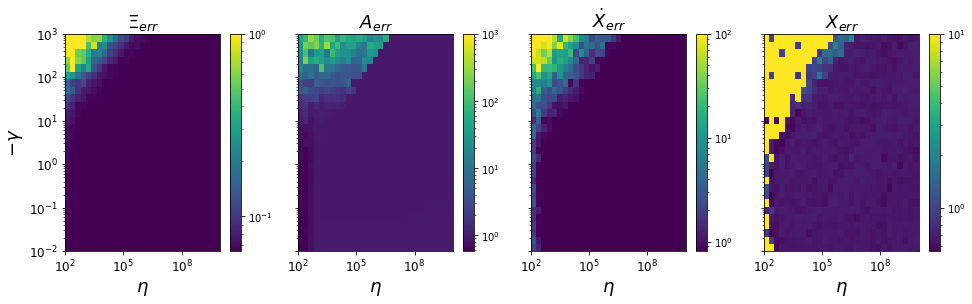

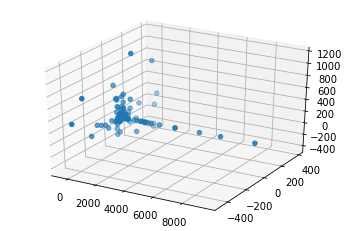

In [40]:
from matplotlib.colors import LogNorm
x_dot = model.differentiate(x_test, t=t)
Xdot = np.asarray(Xdot)
X = np.asarray(X)
Xdot_err = np.zeros((Neta, Neig))
X_err = np.zeros((Neta, Neig))
for i in range(Neta):
    for j in range(Neig):
        Xdot_err[i,j] = np.linalg.norm(Xdot[i*Neig+j, 1:-1, :] - x_dot[1:-1,:])/np.linalg.norm(x_dot[1:-1,:])
        X_err[i,j] = np.linalg.norm(X[i*Neig+j, 1:-1, :] - x_test[1:-1,:])/np.linalg.norm(x_test[1:-1,:])
fs = 18
ts = 12
eta, lam = np.meshgrid(eta_scan, eigmax_scan, indexing='ij')
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.pcolor(eta, lam, Xi_contours/np.linalg.norm(Xi_true), norm=LogNorm(vmin=(Xi_contours/np.linalg.norm(Xi_true)).min(), vmax=1e0))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.ylabel(r'$-\gamma$',fontsize=fs)
plt.title(r'$\Xi_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
plt.subplot(1,4,2)
plt.pcolor(eta, lam, A_contours/np.linalg.norm(As_true), norm=LogNorm(vmin=(A_contours/np.linalg.norm(As_true)).min(), vmax=1e3))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$A_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticklabels([])
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
plt.subplot(1,4,3)
plt.pcolor(eta, lam, Xdot_err,norm=LogNorm(vmin=Xdot_err.min(), vmax=1e2))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$\dot{X}_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])
plt.subplot(1,4,4)
plt.pcolor(eta, lam, X_err,norm=LogNorm(vmin=X_err.min(), vmax=1e1))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$X_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])
    
m_scan = np.asarray(m_scan)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
print(m_scan)
ax.scatter(m_scan[:,0], m_scan[:,1], m_scan[:,2],marker='o')